<a href="https://colab.research.google.com/github/abhaysinghhh/aerialimagesegmentation/blob/main/Aerial_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up colab gpu runtime environment
Install required libraries

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 58.2 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=1f631aaa36add714bb50d90a6365d0b125e347b70a3d01648c96a0bd9c59af0a
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=eeb0f156e356a48139acbff21f533c3c56d47b303b85ed4bf0c6446a3d377812
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Dataset

Here the dataset which we are going to use in this project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

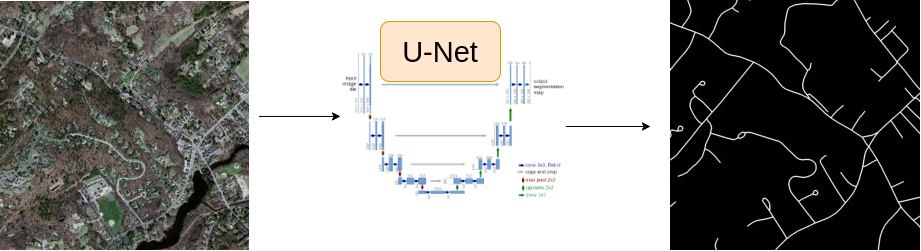

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [ ]:
CSV_FILE = "/content/Road_seg_dataset/train.csv"
DATA_DIR = "/content/Road_seg_dataset/"

DEVICE = 'cuda'

EPOCHS = 15
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.COLOR_BGR2RGB)

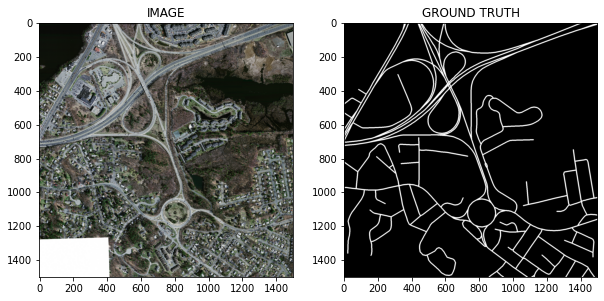

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df,test_size = 0.20,random_state = 42)

# Augmentation Functions

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE,IMG_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE)])

# Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from albumentations import augmentations
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expand_dims(mask,axis = -1) #(h,w,c)
    
    if self.augmentations:
      data = self.augmentations(image = image,mask = mask)
      image = data['image'] #(hieght,width,channel)
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)#(c,h,w)

    image =torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [ ]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
print(len(trainset))
print(len(validset))

159
40


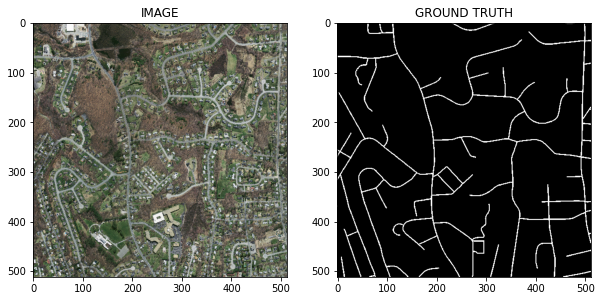

In [ ]:
idx = 31
image, mask = trainset[idx]
helper.show_image(image,mask)

# Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print(len(trainloader))
print(len(validloader))

20
5


In [ ]:
for images, masks in trainloader:
  print(f"One batch image shape : {images.shape}")
  print(f"One batch mask shape : {mask.shape}")
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([1, 512, 512])


# Create Segmentation Model

In [ ]:
#from segmentation_models_pytorch.base.model import SegmentationModel
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights =  WEIGHTS,
        in_channels=3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks = None):
    logits = self.backbone(images)

    if masks!=None:
      return logits, DiceLoss(mode = 'binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits,masks)
    
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16

# Create Train and Validation Function 

In [ ]:
def train_fn(dataloader,model,optimizer):
  model.train() #turn ON dropout,batchnorm etc.

  total_loss = 0.00
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader,model):
  model.eval() #turn OFF dropout,batchnorm etc.

  total_loss = 0.00

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)

      total_loss+=loss.item()

  return total_loss/len(dataloader)

# Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss<best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss
  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 0.7003375947475433 Valid Loss : 0.9105773568153381


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.6647675842046737 Valid Loss : 0.7149654984474182


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.6553265422582626 Valid Loss : 0.6802398800849915


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.6467617869377136 Valid Loss : 0.6801151990890503


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.6305279403924942 Valid Loss : 0.6513389110565185


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch : 6 Train Loss : 0.6241613894701004 Valid Loss : 0.7126369118690491


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch : 7 Train Loss : 0.6171370446681976 Valid Loss : 0.7038630604743957


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED-MODEL
Epoch : 8 Train Loss : 0.6180562615394593 Valid Loss : 0.6401412725448609


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 9 Train Loss : 0.6240455567836761 Valid Loss : 0.6599229574203491


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 10 Train Loss : 0.6048711225390434 Valid Loss : 0.6575599670410156


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch : 11 Train Loss : 0.6136376440525055 Valid Loss : 0.6432793259620666


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED-MODEL
Epoch : 12 Train Loss : 0.6068804740905762 Valid Loss : 0.6377533912658692


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 13 Train Loss : 0.5981119811534882 Valid Loss : 0.653571605682373


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch : 14 Train Loss : 0.5870328262448311 Valid Loss : 0.6592730760574341


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

Epoch : 15 Train Loss : 0.5819422781467438 Valid Loss : 0.6401101469993591


# Inference

In [ ]:
idx = 24

model.load_state_dict(torch.load("/content/best-model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w)->(b,c,h,w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

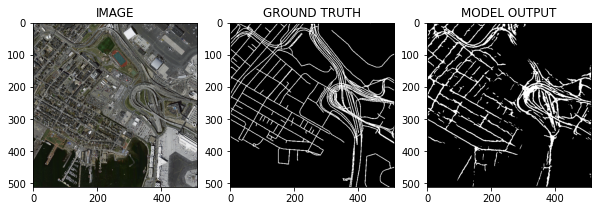

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))